# Replication of Saddle-to-Saddle Dynamics in Diagonal Linear Networks<br>
*Pesme, S., & Flammarion, N. (2024). Saddle-to-saddle dynamics in diagonal linear networks*. Journal of Statistical Mechanics Theory and Experiment, 2024(10), 104016. https://doi.org/10.1088/1742-5468/ad65e3*

#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Button, VBox
import math
from itertools import product, combinations 

## Initialisation and Parameter Values

In [3]:
d = 2 # Dimensions of the input vectors
n = 2 # Number of samples

# Initial values of the weights 
# alpha = 1e-2
# v_0 = np.array([0 for x in range(d)])
# u_0 = math.sqrt(2)*alpha*np.array([1 for x in range(d)])

We generate a dataset for our use. The method of generation is taken from Appendix A

In [4]:
def generate_dataset(n, d):
    # Generate the random parameters for the dataset
    H = np.diag(np.random.rand(d))  # Random diagonal entries for covariance matrix
    beta_star = np.random.randn(d) # Initialize beta^* as a random vector in R^d
    
    # Generate the dataset
    x = np.random.multivariate_normal(np.zeros(d), H, n) # Generate x_i from multivariate normal distribution with mean 0 and covariance H
    y = np.dot(x, beta_star)

    return x, y

# Generate the dataset for fixed H and beta_star
def generate_dataset_fixed_H_beta(n,d,H,beta_star):
    # Generate the dataset
    x = np.random.multivariate_normal(np.zeros(d), H, n) # Generate x_i from multivariate normal distribution with mean 0 and covariance H
    y = np.dot(x, beta_star)

    return x, y

# samples_x, samples_y = generate_dataset(n, d)
# For the sake of consistent results when testing, we will fix the dataset

# Possible TODO: 
#   Calculate the saddle points of the loss F to always predict the saddle points 
#   Take a dataset and replicate the illustrative example in 3.1 with the values to see if it matches similarly

# This dataset gives a weird bump on Beta[0] at the beginning, grows as alpha is larger - Why?
# One jump Beta[0] -> -0.5
# Two jumps Beta[1] -> 1.6 -> 2
# samples_x = np.array([[1, 0.6], [0.2, 0.8]])
# beta_star = np.array([-0.5, 2])

# # Large values break due to some overflow - Take a closer look at why, may be a computer accuracy issue?
# samples_x = np.array([[20, 15], [2, 50]])
# beta_star = np.array([1.5, 20])

# # Converges incredibly fast, time <50 for any alpha value on the sliders
# # This means that the conditions K1-K4 are quickly limiting
# # UNDERSTANDING SO FAR: The time is affected by the gradient of loss L, the values of x and y affect this, in this case we have a 'large' y[1]=8 value
# samples_x = np.array([[0.5, 0.1], [-0.2, 1]])
# beta_star = np.array([-5, 7])

# samples_x = np.array([[0.8, 0.3], [0.1, 0.64]])
# beta_star = np.array([-1.5, 1.4])

# You can see the effect of time scaling much more clearly here
# samples_x = np.array([[0.4, 0.12], [0.13, 0.2]])
# beta_star = np.array([-0.2, 2])

samples_x = np.array([[1, 0.2], [0, math.sqrt(0.1-0.2**2)]])
beta_star = np.array([-0.2, 2])


samples_y = samples_x @ beta_star

samples_y

array([0.2       , 0.48989795])

---
## Important Functions

### 2-layer Diagonal Linear Network
$ x \mapsto \langle u, \sigma(diag(v)x)\rangle $ <br> 
$x \mapsto \langle \beta, x\rangle$ where $\beta = u \odot v$

$u$ - Output weights <br> 
$\sigma$ - Identity function<br> 
$\text{diag}(v)$ - Inner weights<br> 


### Quadratic Loss Function
$L(\beta) = \frac{1}{2n} \sum_{i=1}^{n} (\langle \beta, x_i\rangle - y_i)^2$<br>
$F(\omega) := L(u \odot v)$


In [5]:
# 2-Layer Diagonal Linear Network
def twolDLN(u,v,x):
    return np.inner(u*v, x) # We use the regression vector here for conciseness

# 2-Layer Diagonal Linear Network with beta
def twolDLN_beta(beta,x):
    return np.inner(beta, x) 

# Quadratic Loss Function
def loss(u,v):
    return (1/2*n)*sum([(twolDLN(u,v,samples_x[i])-samples_y[i])**2 for i in range(n)])

def loss_L_beta(beta):
    return (1/2*n)*sum([(twolDLN_beta(beta,samples_x[i])-samples_y[i])**2 for i in range(n)])



### Potential $\phi_\alpha$ - Hyperbolic Entropy function:
$\phi_\alpha(\Beta) = \frac{1}{2} \sum^d_{i=1}\left( \Beta_i \sinh^{-1}(\frac{\Beta_i}{\alpha^2} - \sqrt{\Beta_i^2 +\alpha^4} + \alpha^2)\right)$

In [6]:
def potential(beta, alpha):
    # Ensure beta is a numpy array
    beta = np.array(beta)
    
    # Calculate the function for each beta_i
    result = 1/2*np.sum([beta[i] * np.arcsinh(beta[i] / alpha**2) - np.sqrt(beta[i]**2 + alpha**4) + alpha**2 for i in range(d)])
    
    return result

Time Rescaling for the potential

$\tilde{\phi}_\alpha := \frac{1}{\ln(1/\alpha)} \phi_\alpha$

In [7]:
def scaled_potential(beta, alpha):

    # Rescale the hyperbolic entropy
    result = 1/(math.log(1/alpha)) * potential(beta, alpha)
    
    return result

---
## Gradient Flow

Minimise loss $F$ (without accelerating time)

$\text{d}w_t = - \nabla F(w_t)\text{d}t$

For Gradient descent:
$w_{t+1} = w_t - \eta \nabla F(w_t)$


#### Calculation $\nabla F$
Consider for now only $u$

$\frac{\partial F}{\partial u} = \frac{1}{2n} \sum_{i=1}^n 2(\langle u \odot v,x_i \rangle - y_i) \cdot \frac{\partial}{\partial u}\langle u \odot v, x_i \rangle$

Since $\langle u \odot v, x_i\rangle = \sum_{j=1}^d (u_j v_j x_{ij})$ then $\frac{\partial}{\partial u_j}\langle u \odot v, x_i\rangle = (v_j x_{ij})$

Therefore
$\frac{\partial F}{\partial u} = \frac{1}{n} \sum_{i=1}^n (\langle u \odot v,x_i \rangle - y_i) \cdot (v \odot x_i )$

Similarly 
$\frac{\partial F}{\partial v} = \frac{1}{n} \sum_{i=1}^n (\langle u \odot v,x_i \rangle - y_i) \cdot (u \odot x_i )$

In [8]:
# Partial Derivative of the Loss Function with respect to w
def nabla_F(u,v):
    nabla_F_u = 1/n * sum([(twolDLN(u,v,samples_x[i])-samples_y[i])*(v*samples_x[i]) for i in range(n)])
    nabla_F_v = 1/n * sum([(twolDLN(u,v,samples_x[i])-samples_y[i])*(u*samples_x[i]) for i in range(n)])
    return nabla_F_u, nabla_F_v, np.concatenate((nabla_F_u, nabla_F_v))

def nabla_L(beta):
    nabla_L = 1/n * sum([(twolDLN_beta(beta,samples_x[i])-samples_y[i])*samples_x[i] for i in range(n)])
    return nabla_L

# Gradient Descent on F
def gradient_descent_F(u,v,eta):
    nabla_F_u, nabla_F_v, _ = nabla_F(u,v)
    u = u - eta*nabla_F_u
    v = v - eta*nabla_F_v
    return u, v

# Gradient Descent on L
def gradient_descent_L(beta,eta):
    nabla_beta = nabla_L(beta)
    beta = beta - eta*nabla_beta
    return beta

# Scaled Gradient Descent on L
def gradient_descent_L_scaled(alpha,beta,eta):
    nabla_beta = nabla_L(beta)
    beta = beta - eta* math.log(1/alpha)*nabla_beta
    return beta

#### Visualising the Gradient Flow

We are interested in trying to observe the saddle-to-saddle movements that we may expect.
$\beta$ is the parameter that we pay attention to

Things that we expect to notice:
1. As the $\alpha$ approaches 0, the time required to notice the saddle 'jumps' increases (the time taken for a jump remains the same)
1. When $\alpha$ is very close to 0, then $\Beta$ remains at the origin



In [ ]:
"""
The following code is used to plot the gradient descent path of beta over time for the 2-layer diagonal linear network.
It will only work for d=2, as the plot is in 2D.
"""

def plot_gradient_descent(time=200,eta=0.1,alpha=1e-1):
    # Number of steps for the gradient descent1
    n_steps = math.floor(time / eta)

    # Initial values of the weights
    v_0 = np.array([0 for x in range(d)])
    u_0 = math.sqrt(2)*alpha*np.array([1 for x in range(d)])

    # Gradient Descent
    u = u_0
    v = v_0
    u_values = [u] # Store the values of u for each iteration
    v_values = [v] # Store the values of v for each iteration
    beta_values = [v*u] # Store the values of beta for each iteration
    potential_values = [potential(v*u, alpha)] # Store the values of the potential for each iteration # TODO: Check if this is at all relevant

    # Perform the gradient descent for beta on the loss F
    for _ in range(n_steps):
        u, v = gradient_descent_F(u,v,eta)
        u_values.append(u.copy()) # Save values for plotting
        v_values.append(v.copy()) # Save values for plotting
        beta_values.append(v*u)
        potential_values.append(potential(v*u, alpha))

    # Convert u_values to a numpy array for easier plotting
    u_values = np.array(u_values)
    v_values = np.array(v_values)
    beta_values = np.array(beta_values)
    time_values = np.array([step*eta for step in range(n_steps+1)])

    # PLOTTING FUN

    fig, axs = plt.subplots(1, 2, figsize=(24, 12))
    plt.figure(figsize=(24, 12))
    axs[0].scatter(time_values, beta_values[:, 0], s=0.2, c='purple')
    axs[0].set_title(f'Beta[0] over time (eta = {round(eta,5)}, alpha = {round(alpha,11)})')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Beta[0]')
    axs[0].grid(True)
    axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    axs[0].minorticks_on()

    axs[1].scatter(time_values, beta_values[:, 1], s=0.2, c='purple')
    axs[1].set_title(f'Beta[1] over time (eta = {round(eta,5)}, alpha = {round(alpha,11)})')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Beta[1]')
    axs[1].grid(True)
    axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    axs[1].minorticks_on()

    # Create a button widget
    save_button = Button(description="Save Plot", button_style="success")  # Green button

    # Display the button below the plot
    display(VBox([save_button]))
    plot = plt.gcf()
    plt.show()

        # Save the plot on button click
    def save_plot(p):
        filename = f'plots/Beta[{beta_star[0]},{beta_star[1]}]_Plots_{round(alpha, 5)}_{time}_{round(eta, 5)}.png'  
        fig.savefig(filename)

    save_button.on_click(save_plot) 

# Add sliders to control the parameters
interact(
    plot_gradient_descent,
    time=IntSlider(value=200, min=50, max=1000, step=50, description="Time"),
    eta=FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description="Learning Rate",readout_format='.3f'),
    alpha=FloatSlider(value=0.1, min=1e-8, max=0.1, step=1e-8, description="Alpha",readout_format='.10f'),
)



interactive(children=(IntSlider(value=200, description='Time', max=1000, min=50, step=50), FloatSlider(value=0…

<function __main__.plot_gradient_descent(time=200, eta=0.1, alpha=0.1)>

In [24]:
def gradient_descent(time=200,eta=0.1,alpha=1e-1):
    # Number of steps for the gradient descent1
    n_steps = math.floor(time / eta)

    # Initial values of the weights
    v_0 = np.array([0 for x in range(d)])
    u_0 = math.sqrt(2)*alpha*np.array([1 for x in range(d)])

    # Gradient Descent
    u = u_0
    v = v_0
    u_values = [u] # Store the values of u for each iteration
    v_values = [v] # Store the values of v for each iteration
    beta_values = [v*u] # Store the values of beta for each iteration
    potential_values = [potential(v*u, alpha)] # Store the values of the potential for each iteration # TODO: Check if this is at all relevant

    # Perform the gradient descent for beta on the loss F
    for _ in range(n_steps):
        u, v = gradient_descent_F(u,v,eta)
        u_values.append(u.copy()) # Save values for plotting
        v_values.append(v.copy()) # Save values for plotting
        beta_values.append(v*u)
        potential_values.append(potential(v*u, alpha))

    # Convert u_values to a numpy array for easier plotting
    u_values = np.array(u_values)
    v_values = np.array(v_values)
    beta_values = np.array(beta_values)
    time_values = np.array([step*eta for step in range(n_steps+1)])

    return beta_values, time_values

beta_1, time_1 = gradient_descent(time=3000, eta=0.01, alpha=1e-8)
beta_2, time_2 = gradient_descent(time=2000, eta=0.01, alpha=1e-2)
beta_3, time_3 = gradient_descent(time=1000, eta=0.01, alpha=0.1)
beta_4, time_4 = gradient_descent(time=2000, eta=0.01, alpha=1e-4)


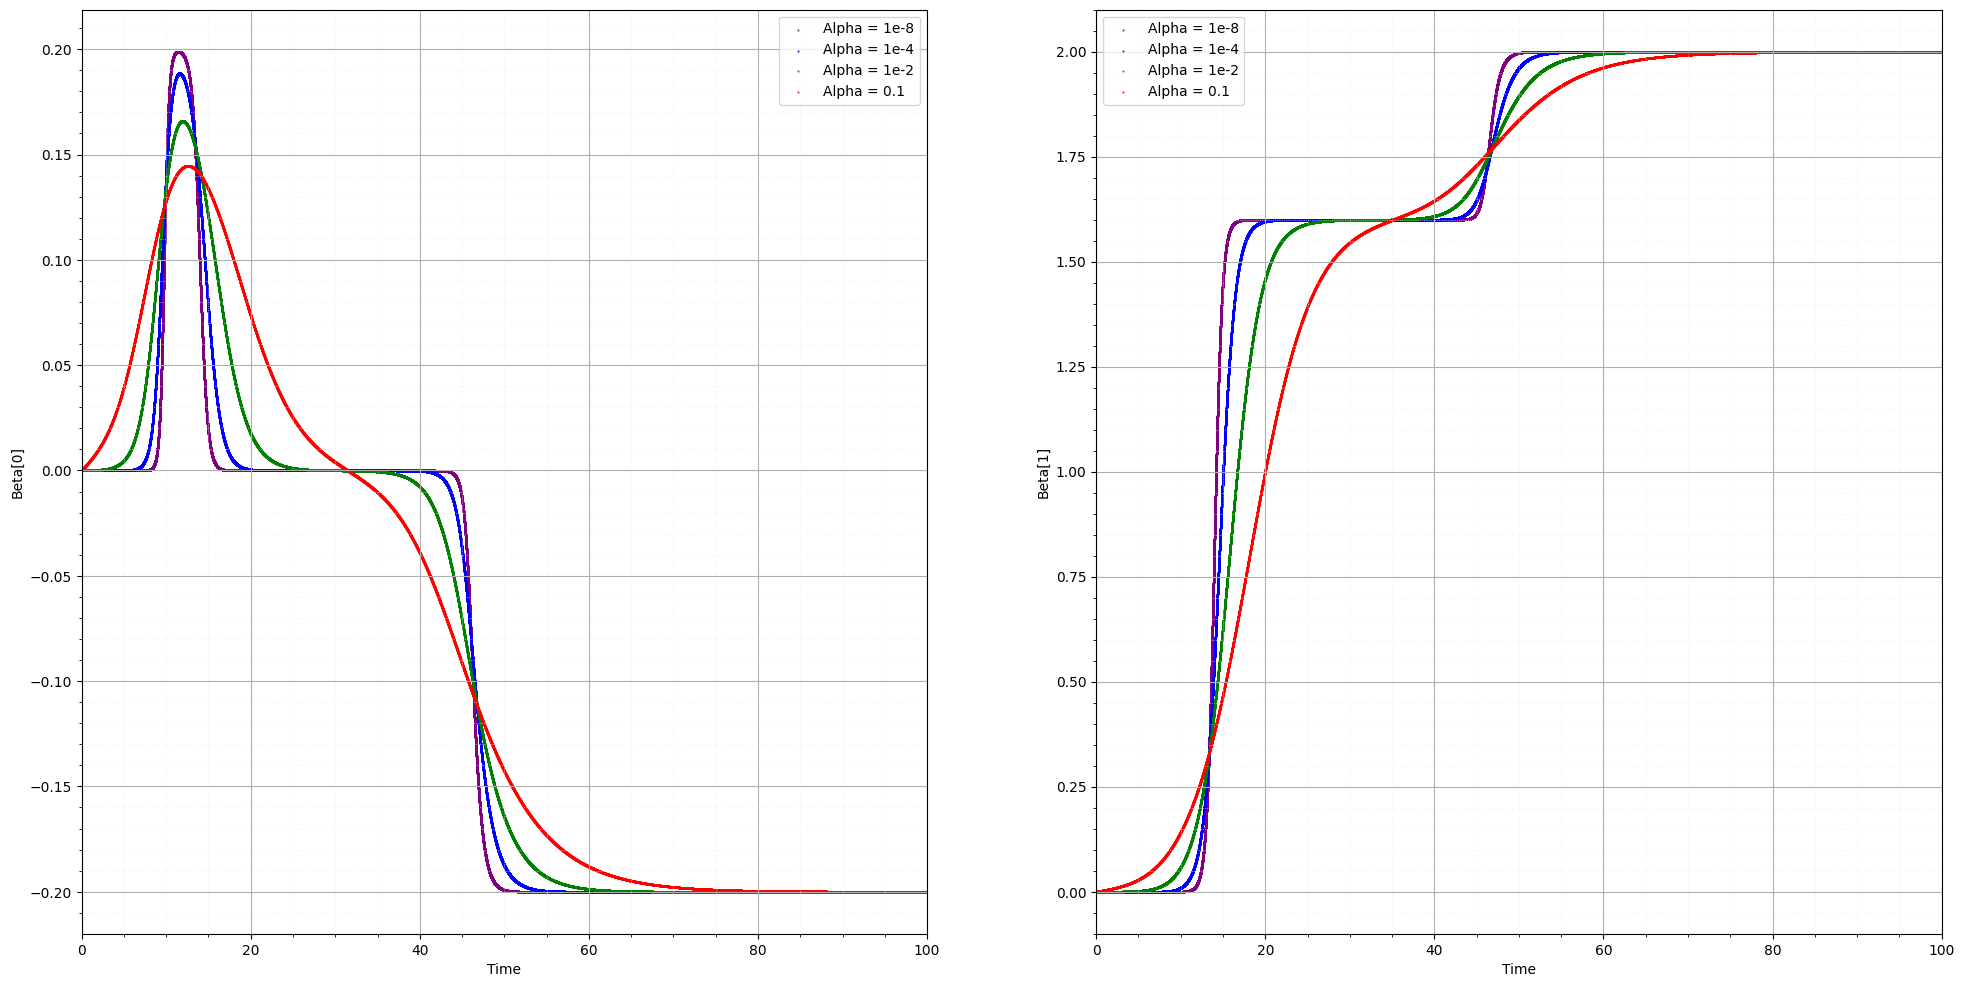

<Figure size 2400x1200 with 0 Axes>

((300001,), (300001, 2))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
plt.figure(figsize=(24, 12))
axs[0].scatter(time_1*(1/math.log(1/1e-8)), beta_1[:, 0], s=0.2, c='purple', label='Alpha = 1e-8')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Beta[0]')
axs[0].grid(True)
axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[0].minorticks_on()

axs[1].scatter(time_1*(1/math.log(1/1e-8)), beta_1[:, 1], s=0.2, c='purple', label='Alpha = 1e-8')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Beta[1]')
axs[1].grid(True)
axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[1].minorticks_on()

axs[0].scatter(time_4*(1/math.log(1/1e-4)), beta_4[:, 0], s=0.22, c='blue', label='Alpha = 1e-4')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Beta[0]')
axs[0].grid(True)
axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[0].minorticks_on()

axs[1].scatter(time_4*(1/math.log(1/1e-4)), beta_4[:, 1], s=0.2, c='blue', label='Alpha = 1e-4')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Beta[1]')
axs[1].grid(True)
axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[1].minorticks_on()



# fig, axs = plt.subplots(1, 2, figsize=(24, 12))
# plt.figure(figsize=(24, 12))
axs[0].scatter(time_2*(1/math.log(1/1e-2)), beta_2[:, 0], s=0.2, c='green', label='Alpha = 1e-2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Beta[0]')
axs[0].grid(True)
axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[0].minorticks_on()

axs[1].scatter(time_2*(1/math.log(1/1e-2)), beta_2[:, 1], s=0.2, c='green', label='Alpha = 1e-2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Beta[1]')
axs[1].grid(True)
axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[1].minorticks_on()




# fig, axs = plt.subplots(1, 2, figsize=(24, 12))
# plt.figure(figsize=(24, 12))
axs[0].scatter(time_3*(1/math.log(1/0.1)), beta_3[:, 0], s=0.2, c='red', label='Alpha = 0.1')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Beta[0]')
axs[0].grid(True)
axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[0].minorticks_on()

axs[1].scatter(time_3*(1/math.log(1/0.1)), beta_3[:, 1], s=0.2, c='red', label='Alpha = 0.1')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Beta[1]')
axs[1].grid(True)
axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[1].minorticks_on()

axs[0].set_xlim(0, 100)
axs[1].set_xlim(0, 100)

axs[0].legend(fontsize = 17)
axs[1].legend(fontsize = 17)

plt.show()

time_1.shape, beta_1.shape

(0.0, 100.0)

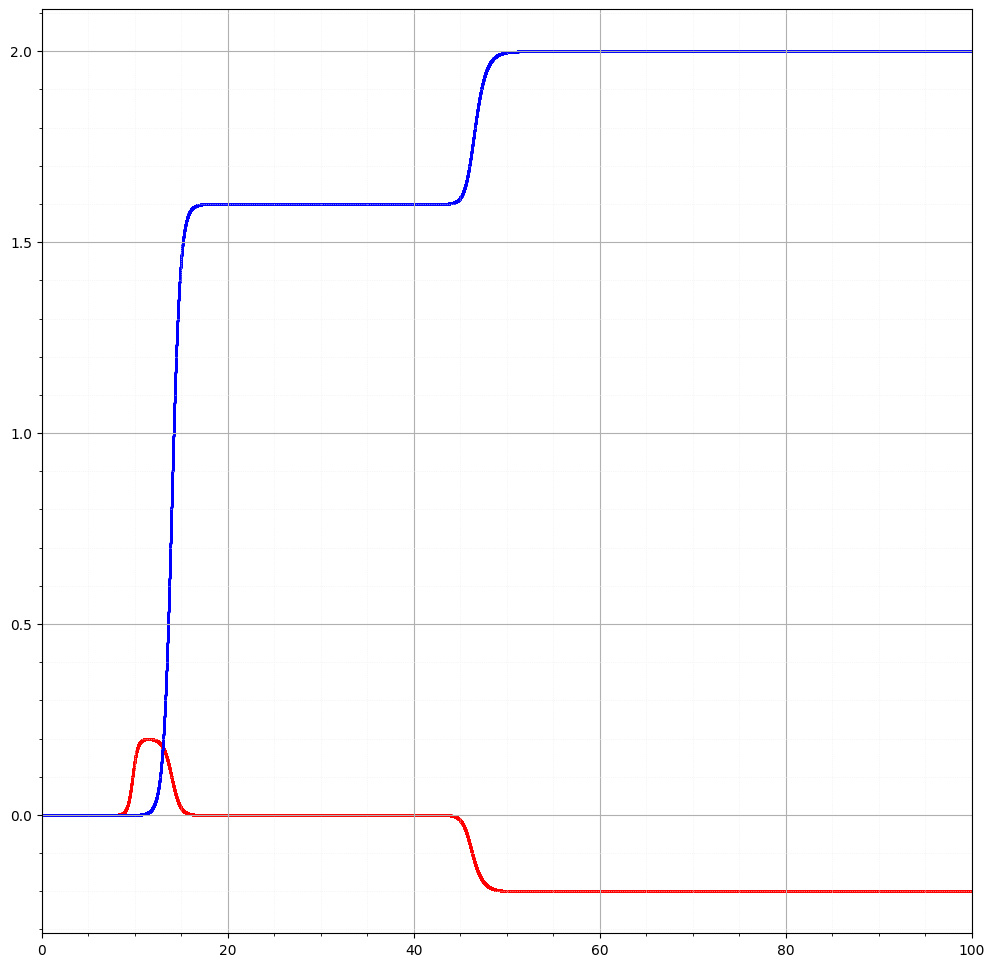

In [27]:
plt.figure(figsize=(12, 12))

plt.scatter(time_1*(1/math.log(1/1e-8)), beta_1[:, 0], s=0.2, c='red', label='Alpha = 1e-30')
plt.grid(True)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.scatter(time_1*(1/math.log(1/1e-8)), beta_1[:, 1], s=0.2, c='blue')
plt.grid(True)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.xlim(0,100)


In [ ]:
# The algorithm is implemented only for the case d=2
def saddle_Algorithm():
    t = 0
    beta = np.array([0, 0])
    s = np.array([0,0])

    arr_t = [t]
    arr_beta = [beta]
    arr_s = [s]

    while (nabla_L(beta)[0] != 0) or (nabla_L(beta)[1] != 0) : #Will it ever be accurate enough to have zero loss?
        print("Starting beta - ", beta)
        beta0_is0 = False
        beta1_is0 = False
        # Step one, add unstable coordinates to a set A
        A = []
        print("nabla_L - ", nabla_L(beta))
        for i in range (d):
            if(nabla_L(beta)[i] != 0):
                A.append(i)

        print("Set A - ", A)

        # Step two, find the time at which a jump occurs
        epsilon = 0.001
        for i in A:
            inf_delta = math.inf
            delta = max((s[i] - 1) / nabla_L(beta)[i],(s[i] + 1) / nabla_L(beta)[i]) # s will only ever hit 1 or -1 in the future, the other is hit in the past
            inf_delta = min(inf_delta, delta)

        print("delta = ", inf_delta)
        # Step three, the time and new s vairables are updated
        t = t + inf_delta
        s = s - inf_delta * nabla_L(beta)
        arr_t.append(t)
        arr_s.append(s)
        print("t - ",t)
        print("s - ",s)
        print("=============")

        # Step four, calculate next saddle that beta jumps to

        # So here we try some funky stuff, the argmin function needs discrete values, so we generate a bunch of values between -5 to 5 in increments of 0.001
        # We simply have to hope this is accurate enough and that the beta values do not go outside this range (this range can be tested in the graphs above)
        lowerbound, upperbound,precision = -2,2,0.01 
        possible_beta_vals = np.arange(lowerbound,upperbound+precision,precision)

        if(s[0] == 1):
            mask0 = (possible_beta_vals >= 0) 
            possible_beta_0 = possible_beta_vals[mask0]
        elif(s[0] == -1):
            mask0 = (possible_beta_vals <= 0)
            possible_beta_0 = possible_beta_vals[mask0]
        else:
            possible_beta_0 = np.array([0]) #We set this manually cos of floating accuracy at the specific value 0, a mask at only 0 can fail
            beta[0] = 0
            beta0_is0 = True

        if(s[1] == 1):
            mask1 = (possible_beta_vals >= 0) 
            possible_beta_1 = possible_beta_vals[mask1]
        elif(s[1] == -1):
            mask1 = (possible_beta_vals <= 0)
            possible_beta_1 = possible_beta_vals[mask1]
        else:
            possible_beta_1 = np.array([0]) #We set this manually cos of floating accuracy at the specific value 0, a mask at only 0 can fail
            beta[1] = 0
            beta1_is0 = True

        number_possible_beta_0 = len(possible_beta_0)
        number_possible_beta_1 = len(possible_beta_1)
        loss_vals = np.empty([number_possible_beta_0,number_possible_beta_1])

        for i in range(number_possible_beta_0):
            for j in range(number_possible_beta_1):
                test_beta = np.array([possible_beta_0[i],possible_beta_1[j]])
                loss_vals[i][j] = loss_L_beta(test_beta)

        argmin = np.argmin(loss_vals,axis=1)

        if(not beta0_is0 and not beta1_is0):
            beta = np.array([possible_beta_0[argmin[0]],possible_beta_1[argmin[1]]])
        elif(not beta0_is0):
            beta[0] = possible_beta_0[argmin[0]]
        elif(not beta1_is0):
            beta[1] = possible_beta_1[argmin[0]]

        arr_beta.append(beta)
        #print(beta) 

saddle_Algorithm()


Starting beta -  [0 0]
nabla_L -  [-2.5 -1.5]
Set A -  [0, 1]
delta =  0.6666666666666667
t -  0.6666666666666667
s -  [1.66666667 1.        ]
Starting beta -  [0 1]
nabla_L -  [ 4.4408921e-16 -5.0000000e-01]
Set A -  [0, 1]
delta =  -0.0
t -  0.6666666666666667
s -  [1.66666667 1.        ]
Starting beta -  [0 1]
nabla_L -  [ 4.4408921e-16 -5.0000000e-01]
Set A -  [0, 1]
delta =  -0.0
t -  0.6666666666666667
s -  [1.66666667 1.        ]
Starting beta -  [0 1]
nabla_L -  [ 4.4408921e-16 -5.0000000e-01]
Set A -  [0, 1]
delta =  -0.0
t -  0.6666666666666667
s -  [1.66666667 1.        ]
Starting beta -  [0 1]
nabla_L -  [ 4.4408921e-16 -5.0000000e-01]
Set A -  [0, 1]
delta =  -0.0
t -  0.6666666666666667
s -  [1.66666667 1.        ]
Starting beta -  [0 1]
nabla_L -  [ 4.4408921e-16 -5.0000000e-01]
Set A -  [0, 1]
delta =  -0.0
t -  0.6666666666666667
s -  [1.66666667 1.        ]
Starting beta -  [0 1]
nabla_L -  [ 4.4408921e-16 -5.0000000e-01]
Set A -  [0, 1]
delta =  -0.0
t -  0.666666666

KeyboardInterrupt: 

---
## Assumptions

##### **(Assumption 1) - General Positions**

For any $k \leq \min(n,d)$ and arbitrary signs $\sigma_1, \dots, \sigma_k \in \{-1,1\}$, the affine span of any $k$ points $\sigma \tilde{x}_{j_1}, \ldots, \sigma \tilde{x}_{j_k}$ does not contain any element of the set $\{ \pm \tilde{x_j}, j \neq j_1, \ldots, j_k\}$


In [ ]:
def check_affine_span(X, k):
    """
    Check if the dataset X satisfies the general position assumption.

    Parameters:
    X (numpy array): Dataset with shape (n, d), where n is the number of samples and d is the dimensionality.
                     The ith column of X corresponds to the feature vector x_̃j in the assumption.
    k (int): Number of points to check in the affine span. Must be <= min(n, d).

    Returns:
    bool: True if the assumption holds, False otherwise.

    Warning: 
    This function has exponential complexity in d and k. It is only suitable for small values of d and k.
    """
    # Generate all combinations of k columns and their corresponding sign combinations
    for indices in combinations(range(d), k): # all combinations of k columns
        for signs in product([-1, 1], repeat=k): # all sign combinations
            # Select k columns (corresponding to features) and apply sign changes
            selected_columns = np.array([sign * X[:, idx] for sign, idx in zip(signs, indices)]).T  # Make array of all selected columns and their signs
            
            # Compute the affine span of the selected columns
            # (Affine span is equivalent to checking linear independence after centering the points)
            centered_columns = selected_columns - selected_columns.mean(axis=0) #Centering is necessary for checking the #affine# span not just the linear span
            if np.linalg.matrix_rank(centered_columns) < k:
                continue  # If points are linearly dependent, skip this combination
            
            # Now check if any other columns lie in the affine span
            remaining_indices = [i for i in range(d) if i not in indices] # Columns not in the selected set
            for idx in remaining_indices:
                for sign in [-1, 1]:
                    candidate_column = sign * X[:, idx]
                    augmented_matrix = np.hstack([centered_columns, candidate_column[:, None] - selected_columns.mean(axis=0)])
                    if np.linalg.matrix_rank(augmented_matrix) == k:
                        # If the rank doesn't increase, the point lies in the affine span
                        return False
    
    return True

In [ ]:
k = min(d, n)  # Minimum of d and n for general positions

for i in range(1, k+1):
    if not check_affine_span(samples_x, i):
        print("General position assumption is not satisfied for k = ", i)
    else:
        print("General position assumption is satisfied for k = ", i)

General position assumption is satisfied for k =  1
General position assumption is satisfied for k =  2


Generating graphs for Phi as Alpha goes to 0

Text(0.5, 1.0, 'Plot $\\phi_\\alpha(x)$ for $\\alpha = 0.001$')

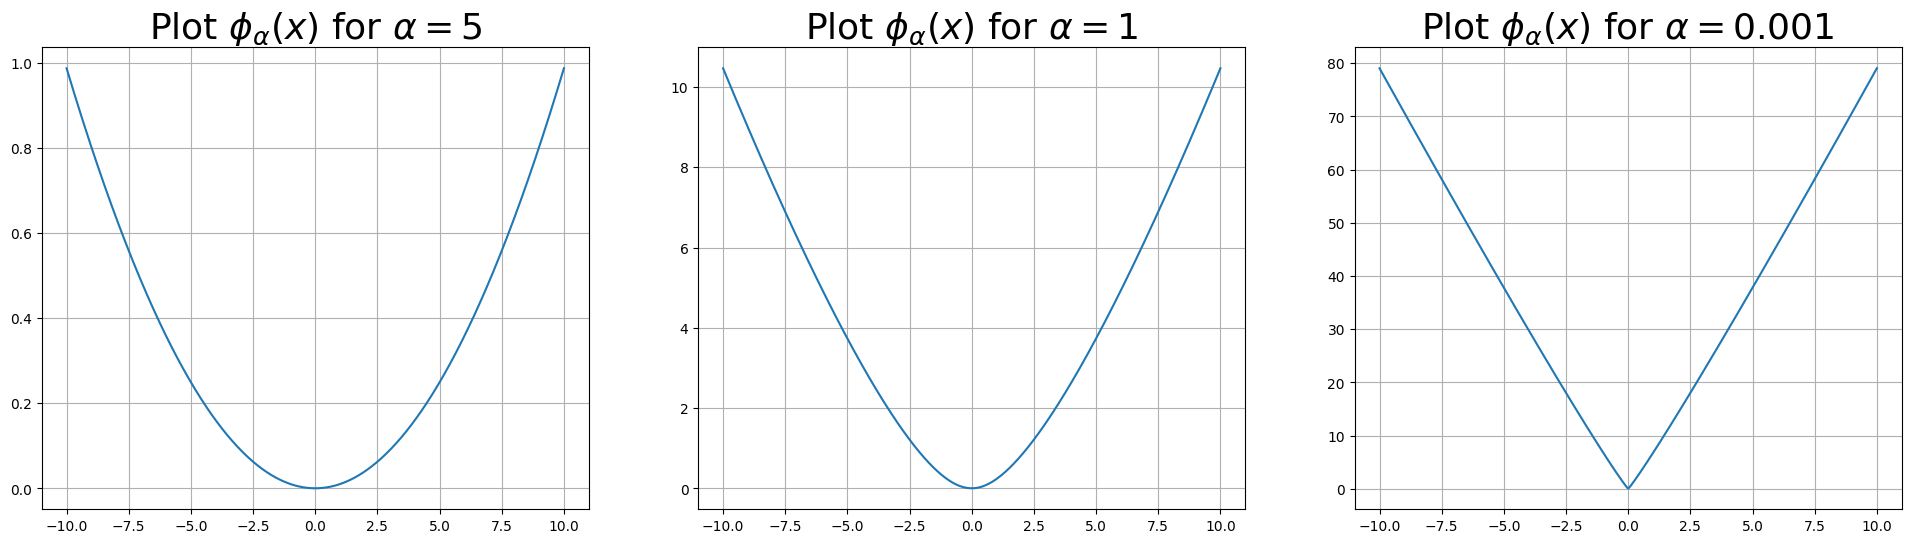

In [ ]:
# Generate x values
x = np.linspace(-10, 10, 500)  # 500 points for smooth curve
alpha = 5
# Compute y values
y_1 = 1/2*(x * np.arcsinh(x / alpha**2) - np.sqrt(x**2 + alpha**4) + alpha**2)

alpha = 1
y_2 = 1/2*(x * np.arcsinh(x / alpha**2) - np.sqrt(x**2 + alpha**4) + alpha**2)

alpha = 0.001
y_3 = 1/2*(x * np.arcsinh(x / alpha**2) - np.sqrt(x**2 + alpha**4) + alpha**2)
# Plot the function
font = 26
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(24, 6))
ax1.plot(x, y_1)
ax1.grid(True)
ax1.set_title(r'Plot $\phi_\alpha(x)$ for $\alpha = 5$',fontsize=font)

ax2.plot(x, y_2)
ax2.grid(True)
ax2.set_title(r'Plot $\phi_\alpha(x)$ for $\alpha = 1$',fontsize=font)

ax3.plot(x, y_3)
ax3.grid(True)
ax3.set_title(r'Plot $\phi_\alpha(x)$ for $\alpha = 0.001$',fontsize=font)